En este archivo puedes escribir lo que estimes conveniente. Te recomendamos detallar tu solución y todas las suposiciones que estás considerando. Aquí puedes ejecutar las funciones que definiste en los otros archivos de la carpeta src, medir el tiempo, memoria, etc.

## Reading Files

### Import Libraries

In [2]:
#! pip install -U memory_profiler

In [1]:
import json
import pandas as pd
import pyspark
import zipfile
from pyspark.sql import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import warnings
import emoji
import time
warnings.filterwarnings('ignore')
%load_ext memory_profiler

### Converting zip to gz

In [68]:
%%bash
cd ../data
#unzip -p ../data/farmers-tweets.json.zip | gzip > farmers-tweets.json.gz
unzip -p ../data/farmers-protest-tweets-2021-2-4.json.zip | gzip > farmers-protest-tweets-2021-2-4.json.gz

### Reading tweets as pyspark object

Initially the data is a sample of tweets `./data/farmers-tweets.json`, afterwards I will load the complete json file

In [2]:
namef = '../data/farmers-protest-tweets-2021-2-4'
#namef = 'farmers-tweets'

file_path = namef+'.json.gz'
print(f"** File to use: {file_path}")

** File to use: ../data/farmers-protest-tweets-2021-2-4.json.gz


The first test is perform the data loading over a RDD spark object.
`%memit` magic cell allow us measure memory.

*Note: The spark.read.json is running in the .gz file

In [86]:
%memit
#Creating SparkSession 
spark = SparkSession.builder.appName('readJson').getOrCreate()
#Read file as pyspark object()   
data = spark.read.json(file_path)
#transformation and renaming columns steps
dfcol = data.withColumn("created_at", data["date"].cast('date'))\
                                .withColumn("user_id", data["user.id"])\
                                .withColumn("username", data["user.username"])

df = dfcol.select(col("created_at"), col("user_id"), col("username")).groupBy("created_at", "username").count()
df.sort(df["count"].desc()).show(10) 

peak memory: 1198.84 MiB, increment: 0.22 MiB


+----------+---------------+-----+
|created_at|       username|count|
+----------+---------------+-----+
|2021-02-19|       Preetm91|  267|
|2021-02-18|neetuanjle_nitu|  195|
|2021-02-17| RaaJVinderkaur|  185|
|2021-02-13|MaanDee08215437|  178|
|2021-02-12|RanbirS00614606|  176|
|2021-02-21|     Surrypuria|  161|
|2021-02-18|  rebelpacifist|  153|
|2021-02-19|KaurDosanjh1979|  138|
|2021-02-23|     Surrypuria|  135|
|2021-02-15|         jot__b|  134|
+----------+---------------+-----+
only showing top 10 rows



### Reading tweets as pandas df

The second tool to solve questions is make transformations over dataframes.

Let's check results:

In [9]:
#file_path = "../data/farmers-tweets.json"
file_path = '../data/farmers-protest-tweets-2021-2-4.json'

In [78]:
#Read file with json.loads()   
data = [json.loads(line) for line in open(file_path, 'r')]
#convert to dataframe
df = pd.DataFrame(data)
#transformation and renaming columns steps
df["created_at"] = pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')
#lambda functions to create new columns from user tag
df['username'] = df['user'].apply(lambda d: d['username'])
df['user_id'] = df['user'].apply(lambda d: d['id'])

dfres = df.groupby(['created_at','username'])['id'].count().reset_index(name="count").sort_values("count", ascending=False) 

print(dfres.head(10))

       created_at         username  count
35219  2021-02-19         Preetm91    267
33193  2021-02-18  neetuanjle_nitu    195
26577  2021-02-17   RaaJVinderkaur    185
7536   2021-02-13  MaanDee08215437    178
2740   2021-02-12  RanbirS00614606    176
42691  2021-02-21       Surrypuria    161
33396  2021-02-18    rebelpacifist    153
34733  2021-02-19  KaurDosanjh1979    138
48696  2021-02-23       Surrypuria    135
18540  2021-02-15           jot__b    134


## Memory Profiler

This is a python module for monitoring memory consumption of a process as well as line-by-line analysis of memory consumption for python programs.

Let's track output lines for each function and use `%mprun` magic command to measure memory usage.

### Spark function

Note: Now I'm gonna take all tweets from Json files:

1. Evaluate memory consumption for q1_memory Spark ETL:

In [2]:
from q1_memory import q1_memory
file_path = "../data/farmers-protest-tweets-2021-2-4.json.gz"
%mprun -f q1_memory q1_memory(file_path)

24/03/17 10:58:11 WARN Utils: Your hostname, Julians-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.6 instead (on interface en0)
24/03/17 10:58:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/17 10:58:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/17 10:58:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


[(datetime.date(2021, 2, 19), 'Preetm91'), (datetime.date(2021, 2, 18), 'neetuanjle_nitu'), (datetime.date(2021, 2, 17), 'RaaJVinderkaur'), (datetime.date(2021, 2, 13), 'MaanDee08215437'), (datetime.date(2021, 2, 12), 'RanbirS00614606'), (datetime.date(2021, 2, 21), 'Surrypuria'), (datetime.date(2021, 2, 18), 'rebelpacifist'), (datetime.date(2021, 2, 19), 'KaurDosanjh1979'), (datetime.date(2021, 2, 23), 'Surrypuria'), (datetime.date(2021, 2, 15), 'jot__b')]



Filename: /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_memory.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     9    106.4 MiB    106.4 MiB           1   def q1_memory(file_path: str) -> List[Tuple[datetime.date, str]]:
    10                                             
    11                                             #Creating SparkSession 
    12    109.2 MiB      2.8 MiB           1       spark = SparkSession.builder.appName('readJson').getOrCreate()
    13                                             #Read file as pyspark object()   
    14    107.0 MiB     -2.2 MiB           1       data = spark.read.json(file_path)    
    15                                             #transformation and renaming columns steps
    16    107.1 MiB      0.1 MiB           2       dfcol = data.withColumn("created_at", data["date"].cast('date'))\
    17    107.1 MiB      0.0 MiB           1                                   .withColumn("user_id", data["user.id"])\
 

24/03/17 10:58:26 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


A first overview in this transformation, it produces a low memory consumption.

### Pandas Function

2. Evaluate memory consumption for q1_time dataframe ETL:

In [83]:
from q1_time import q1_time
file_path = "../data/farmers-protest-tweets-2021-2-4.json"
%mprun -f q1_time q1_time(file_path)

       created_at         username  count
35219  2021-02-19         Preetm91    267
33193  2021-02-18  neetuanjle_nitu    195
26577  2021-02-17   RaaJVinderkaur    185
7536   2021-02-13  MaanDee08215437    178
2740   2021-02-12  RanbirS00614606    176
42691  2021-02-21       Surrypuria    161
33396  2021-02-18    rebelpacifist    153
34733  2021-02-19  KaurDosanjh1979    138
48696  2021-02-23       Surrypuria    135
18540  2021-02-15           jot__b    134



Filename: /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_time.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    10    123.9 MiB    123.9 MiB           1   def q1_time(file_path: str) -> List[Tuple[datetime.date, str]]:
    11                                             
    12                                             #Read file with json.loads()   
    13   2263.2 MiB -499104.4 MiB      117410       data = [json.loads(line) for line in open(file_path, 'r')]
    14                                             #convert to dataframe
    15   2349.5 MiB     86.3 MiB           1       df = pd.DataFrame(data)
    16                                             #transformation and renaming columns steps
    17   2359.0 MiB      9.6 MiB           1       df["created_at"] = pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')
    18   2359.0 MiB -2460732.0 MiB      234815       df['username'] = df['user'].apply(lambda d: d['username'])
    19   2298.9 MiB    -60.2 M

A considerable and highly use of memory here.

### Generating memory usage reports with `mprof` and `plot`

### Spark Function

Let's run the next `bash` code in terminal to generate memory statistics for code lines. After `plot` the results:

In [88]:
%%bash
echo mprof run /Users/julianromero/.local/share/virtualenvs/ProcessTweets-raqGfvtZ/bin/python /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_memory.py

mprof run /Users/julianromero/.local/share/virtualenvs/ProcessTweets-raqGfvtZ/bin/python /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_memory.py


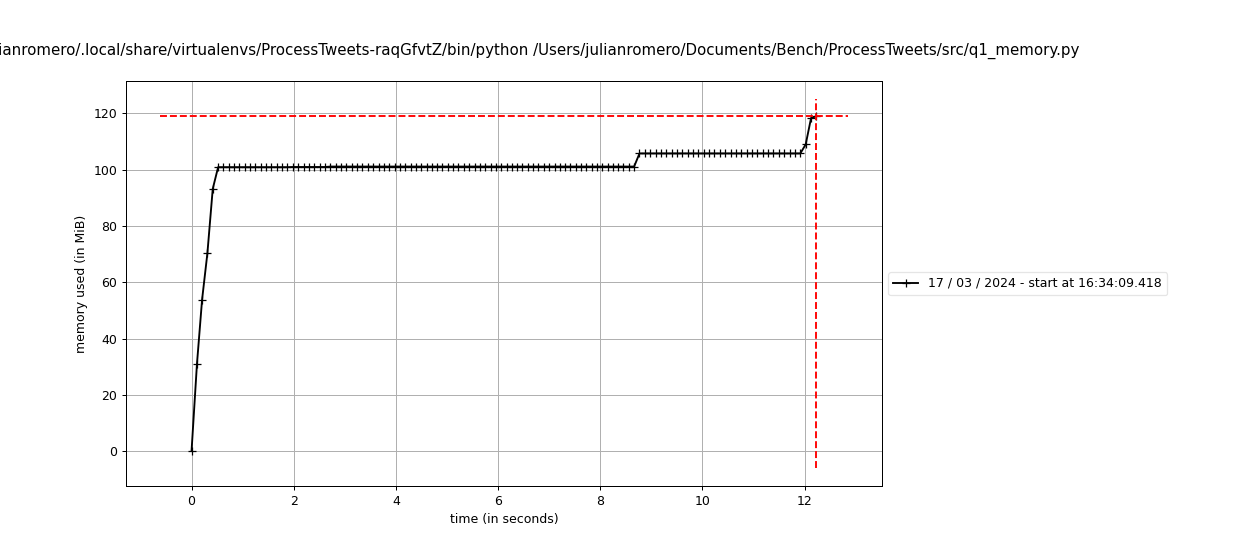

### Pandas Function

In [3]:
%%bash
echo mprof run /Users/julianromero/.local/share/virtualenvs/ProcessTweets-raqGfvtZ/bin/python /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_time.py

mprof run /Users/julianromero/.local/share/virtualenvs/ProcessTweets-raqGfvtZ/bin/python /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_time.py


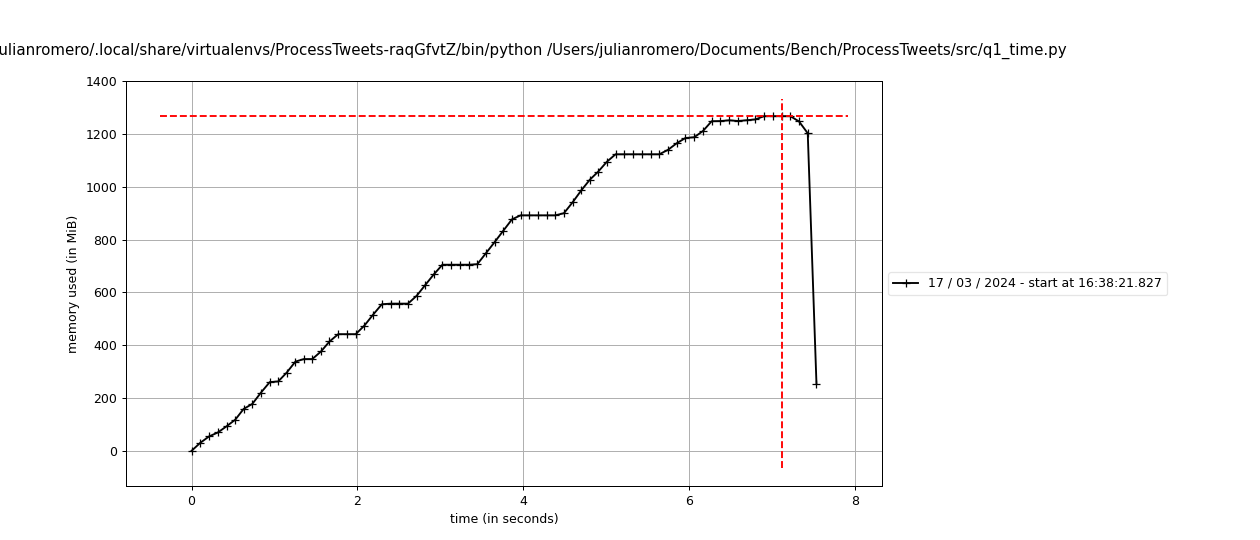

This two interesting plots show us the task activities (lines code) inside the function. The q1_memory functions takes no more than 120 Mb of memory and run almost in 12 seconds. On the opossite way pandas implementation show us less (the half than spark) time for execution but demands 10x memory.

For example we can denote the difference between this two approaches. Spark run efficiently avoiding memory consumption.
On the other side pandas run faster in this exercise but consuming a high volume memory, almost over 10x.


### Solving 1st Challenge

Top 10 dates with more tweets. Mention the username who has more publications for those dates:

Keep the next functions:
```python
def q1_time(file_path: str) -> List[Tuple[datetime.date, str]]:

def q1_memory(file_path: str) -> List[Tuple[datetime.date, str]]:
```

The way that I'm gonna tackle this problem, is writing two functions based on:

1. Memory: I'll load and process the information related with tweets on pyspark object, leverage the process engine of Spark and its memory management with RDD's
2. Time: I'll use a transformation process directly with pandas in order to check the differences between Spark.

Also for each function I've implemented best practies and features to reduce the recources consumption, like:

- Make inplace tranformations to dataframe.
- Process the data load as minimum compressed format.
- Exploring columns which are relevant for each analysis.
- Reduce data types conversion.

Note: The execution time and usage memory significantly enhance with Spark process. Meanwhile pandas job peak´s the memory until 10x than Spark job do also a major time running execution.

In [5]:
#Creating SparkSession 
spark = SparkSession.builder.appName('readJson').getOrCreate()
#Read file as pyspark object()   
data = spark.read.json(file_path)
#transformation and renaming columns steps
dfcol = data.withColumn("created_at", data["date"].cast('date'))\
                                .withColumn("user_id", data["user.id"])\
                                .withColumn("username", data["user.username"])

dfaux = dfcol.select(col("created_at"), col("user_id"), col("username")).groupBy("created_at", "username").count()
#df.sort(df["count"].desc()).show(10)   
    
#Convert to pandas df sorted   
df = dfaux.toPandas().sort_values("count", ascending=False)    

#Printing tuples as datetime.date format
print(list(df[['created_at','username']].head(10).itertuples(index=False, name=None)))   

[(datetime.date(2021, 2, 19), 'Preetm91'), (datetime.date(2021, 2, 18), 'neetuanjle_nitu'), (datetime.date(2021, 2, 17), 'RaaJVinderkaur'), (datetime.date(2021, 2, 13), 'MaanDee08215437'), (datetime.date(2021, 2, 12), 'RanbirS00614606'), (datetime.date(2021, 2, 21), 'Surrypuria'), (datetime.date(2021, 2, 18), 'rebelpacifist'), (datetime.date(2021, 2, 19), 'KaurDosanjh1979'), (datetime.date(2021, 2, 23), 'Surrypuria'), (datetime.date(2021, 2, 15), 'jot__b')]


### Time tracking

Calling function def `q1_memory(file_path: str)`

I´ll use `time` module to measure time execution for each function call.

In [4]:
from q1_memory import q1_memory
start = time.time()
file_path = "../data/farmers-protest-tweets-2021-2-4.json.gz"
%mprun -f q1_memory q1_memory(file_path)
end = time.time()
timer = end - start
print(f"Time elapsed: {timer:.2f} seconds")

[(datetime.date(2021, 2, 19), 'Preetm91'), (datetime.date(2021, 2, 18), 'neetuanjle_nitu'), (datetime.date(2021, 2, 17), 'RaaJVinderkaur'), (datetime.date(2021, 2, 13), 'MaanDee08215437'), (datetime.date(2021, 2, 12), 'RanbirS00614606'), (datetime.date(2021, 2, 21), 'Surrypuria'), (datetime.date(2021, 2, 18), 'rebelpacifist'), (datetime.date(2021, 2, 19), 'KaurDosanjh1979'), (datetime.date(2021, 2, 23), 'Surrypuria'), (datetime.date(2021, 2, 15), 'jot__b')]

Time elapsed: 5.78 seconds


Filename: /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_memory.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     9     63.5 MiB     63.5 MiB           1   def q1_memory(file_path: str) -> List[Tuple[datetime.date, str]]:
    10                                             
    11                                             #Creating SparkSession 
    12     65.3 MiB      1.9 MiB           1       spark = SparkSession.builder.appName('readJson').getOrCreate()
    13                                             #Read file as pyspark object()   
    14     65.9 MiB      0.6 MiB           1       data = spark.read.json(file_path)    
    15                                             #transformation and renaming columns steps
    16     66.1 MiB      0.2 MiB           2       dfcol = data.withColumn("created_at", data["date"].cast('date'))\
    17     66.1 MiB      0.0 MiB           1                                   .withColumn("user_id", data["user.id"])\
 

Calling function def `q1_time(file_path: str)`

In [5]:
from q1_time import q1_time
start = time.time()
file_path = "../data/farmers-protest-tweets-2021-2-4.json"
%mprun -f q1_time q1_time(file_path)
end = time.time()
timer = end - start
print(f"Time elapsed: {timer:.2f} seconds")

[('2021-02-19', 'Preetm91'), ('2021-02-18', 'neetuanjle_nitu'), ('2021-02-17', 'RaaJVinderkaur'), ('2021-02-13', 'MaanDee08215437'), ('2021-02-12', 'RanbirS00614606'), ('2021-02-21', 'Surrypuria'), ('2021-02-18', 'rebelpacifist'), ('2021-02-19', 'KaurDosanjh1979'), ('2021-02-23', 'Surrypuria'), ('2021-02-15', 'jot__b')]

Time elapsed: 14.60 seconds


Filename: /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_time.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    10     70.3 MiB     70.3 MiB           1   def q1_time(file_path: str) -> List[Tuple[datetime.date, str]]:
    11                                             
    12                                             #Read file with json.loads()   
    13   1185.3 MiB   1114.0 MiB      117410       data = [json.loads(line) for line in open(file_path, 'r')]
    14                                             #convert to dataframe
    15   1269.2 MiB     83.8 MiB           1       df = pd.DataFrame(data)
    16                                             #transformation and renaming columns steps
    17   1277.3 MiB      8.2 MiB           1       df["created_at"] = pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')
    18   1277.3 MiB -93674.5 MiB      234815       df['username'] = df['user'].apply(lambda d: d['username'])
    19   1280.3 MiB      3.0 MiB 

Same results usage memory significantly enhance with Spark process. Meanwhile pandas job peak´s the memory until 10x than Spark job do also a major time running execution.

### Solving 2nd Challenge

Top 10 most used emojis with their count.

Keep the next functions:
```python
def q2_time(file_path: str) -> List[Tuple[str, int]]:

def q2_memory(file_path: str) -> List[Tuple[str, int]]:    
```

### EDA

Exploring twitter posts, I found a relation between the `content` and `user.id` what causes a duplicate content field. This behavior seems to be realated to the same tweet, as you can observe.

For Instance: Two existing records represent the same tweet posted by the same `user.id` But they have different attributes for `date` and `id`.
Trying to find relevant differences the `quotedTweet` tag has different `conversationId`:

tweet1
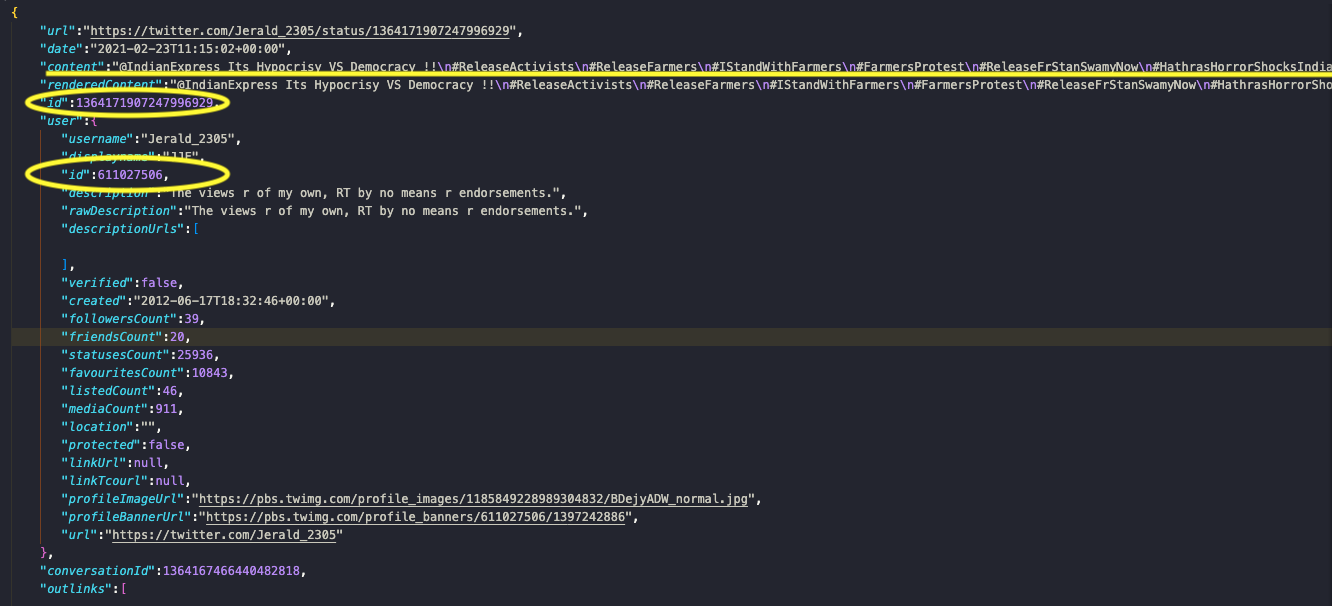
tweet2
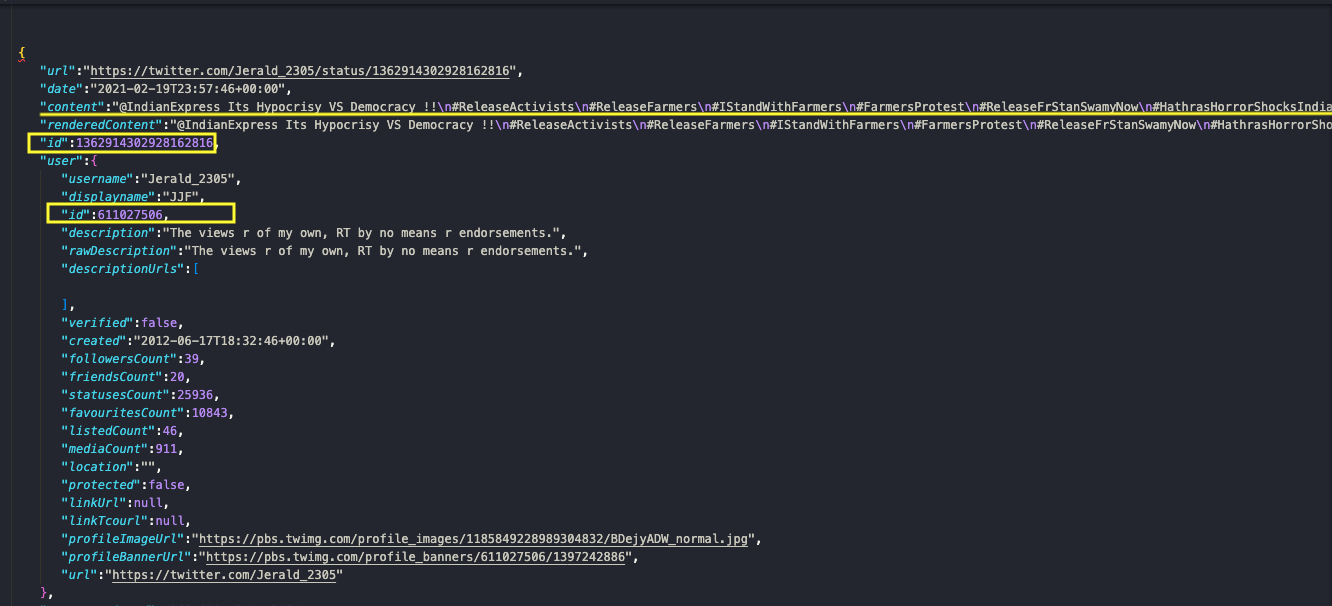

The results are affected in all questions by this behavior.

The count emoji analysis shows different results, droping duplicates and by the other hand treating with the entire data.

Acoording to the information purposes and knowing that we´re working with different `id` and `conversationId` data, analysis will preserve all the tweets.

### Analysis Droping Duplicates

Let's see results dropping duplicate data by `['content','user.id']`

In [12]:
#file_path = "../data/farmers-tweets.json"
file_path = '../data/farmers-protest-tweets-2021-2-4.json'

In [13]:
##Read file with json.loads()   
data = [json.loads(line) for line in open(file_path, 'r')]
#convert to dataframe
df = pd.DataFrame(data)
#transformation and renaming columns steps    
df['user_id'] = df['user'].apply(lambda d: d['id'])
#Duplicate tweets by user_id and content findings
print(df.shape)
df=df.drop_duplicates(subset=['content','user_id'])
print(df.shape)
#dfres = df.groupby(['content','user_id'])['id'].count().reset_index(name="count").sort_values("count", ascending=False)      
#print(dfres.query('count > 1').head(10))  

dfres = df[['content','id']]

text = dfres['content'].str.cat(sep='\n')    
out = (pd.DataFrame(emoji.emoji_list(text)).value_counts('emoji')
        .rename_axis('Smiley').rename('Count').reset_index()
        .assign(Type=lambda x: x['Smiley'].apply(emoji.demojize)))

print(list(out[['Smiley','Count']].head(10).itertuples(index=False, name=None)))

(117407, 22)
(115624, 22)
[('🙏', 4991), ('😂', 3068), ('🚜', 2899), ('🌾', 2164), ('🇮🇳', 2085), ('🤣', 1660), ('✊', 1633), ('❤️', 1378), ('🙏🏻', 1299), ('💚', 1036)]


A less count records by emoji.

### Analysis Whole Data

Let's see results with all data.

Note: Try to reduce records by `['content','id']` but the id's are unique on those.

In [14]:
##Read file with json.loads()   
data = [json.loads(line) for line in open(file_path, 'r')]
#convert to dataframe
df = pd.DataFrame(data)
#transformation and renaming columns steps    
#Duplicate tweets by user_id and content findings
print(df.shape)
df=df.drop_duplicates(subset=['content','id'])
print(df.shape)
#dfres = df.groupby(['content','user_id'])['id'].count().reset_index(name="count").sort_values("count", ascending=False)      
#print(dfres.query('count > 1').head(10))  

dfres = df[['content','id']]

text = dfres['content'].str.cat(sep='\n')    
out = (pd.DataFrame(emoji.emoji_list(text)).value_counts('emoji')
        .rename_axis('Smiley').rename('Count').reset_index()
        .assign(Type=lambda x: x['Smiley'].apply(emoji.demojize)))

print(list(out[['Smiley','Count']].head(10).itertuples(index=False, name=None)))

(117407, 21)
(117407, 21)
[('🙏', 5049), ('😂', 3072), ('🚜', 2972), ('🌾', 2182), ('🇮🇳', 2086), ('🤣', 1668), ('✊', 1651), ('❤️', 1382), ('🙏🏻', 1317), ('💚', 1040)]


Expected result with all data.

### `q2_memory` Improving memory

In [6]:
from q2_memory import q2_memory
start = time.time()
file_path = "../data/farmers-protest-tweets-2021-2-4.json.gz"
%mprun -f q2_memory q2_memory(file_path)
end = time.time()
timer = end - start
print(f"Time elapsed: {timer:.2f} seconds")

[('🙏', 5049), ('😂', 3072), ('🚜', 2972), ('🌾', 2182), ('🇮🇳', 2086), ('🤣', 1668), ('✊', 1651), ('❤️', 1382), ('🙏🏻', 1317), ('💚', 1040)]

Time elapsed: 100.46 seconds


Filename: /Users/julianromero/Documents/Bench/ProcessTweets/src/q2_memory.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    11     71.5 MiB     71.5 MiB           1   def q2_memory(file_path: str) -> List[Tuple[str, int]]:
    12                                             #Creating SparkSession 
    13     73.0 MiB      1.5 MiB           1       spark = SparkSession.builder.appName('readJson').getOrCreate()
    14                                             #Read file as pyspark object()   
    15     73.7 MiB      0.7 MiB           1       data = spark.read.json(file_path)            
    16                                             #Selection only the columns to process to enhance time and usage memory consumption
    17     73.9 MiB      0.2 MiB           1       dfaux = data.select(col("content"), col("id"))
    18    181.4 MiB    107.5 MiB           1       df = dfaux.toPandas() 
    19                                             #Creating string for each co

### `q2_time` Improving time

In [7]:
from q2_time import q2_time
start = time.time()
file_path = "../data/farmers-protest-tweets-2021-2-4.json"
%mprun -f q2_time q2_time(file_path)
end = time.time()
timer = end - start
print(f"Time elapsed: {timer:.2f} seconds")

[('🙏', 5049), ('😂', 3072), ('🚜', 2972), ('🌾', 2182), ('🇮🇳', 2086), ('🤣', 1668), ('✊', 1651), ('❤️', 1382), ('🙏🏻', 1317), ('💚', 1040)]

Time elapsed: 103.26 seconds


Filename: /Users/julianromero/Documents/Bench/ProcessTweets/src/q2_time.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    11    105.3 MiB    105.3 MiB           1   def q2_time(file_path: str) -> List[Tuple[str, int]]:
    12                                             
    13                                             ##Read file with json.loads()   
    14   1185.7 MiB  -5164.0 MiB      117410       data = [json.loads(line) for line in open(file_path, 'r')]
    15                                             #convert to dataframe
    16   1257.0 MiB     71.3 MiB           1       df = pd.DataFrame(data)
    17                                             #Selection only the columns to process to enhance time and usage memory consumption
    18   1257.3 MiB      0.2 MiB           1       dfres = df[['content','id']]
    19                                             #Creating string for each content
    20   1286.8 MiB     29.5 MiB           1       text = dfres['co

Similar results here. The transformation process begin loading the data in RDD object, we can view the usage memory significantly enhance with Spark process. At the half of the process it's implemented the conversion to pandas dataframe to apply some useful functions to solve the exercises. Meanwhile pandas job peak´s the memory until 10x than Spark job do also a major time running execution.

### Solving 3rd Challenge

Top 10 users with more retweets(@)

Keep the next functions:
```python
def q3_time(file_path: str) -> List[Tuple[str, int]]:

def q3_memory(file_path: str) -> List[Tuple[str, int]]:
```

### `q3_memory` Improving memory

For this task I'm gonna use only the content field to found who has the most mentions:

In [7]:
from q3_memory import q3_memory
start = time.time()
file_path = "../data/farmers-protest-tweets-2021-2-4.json.gz"
%mprun -f q3_memory q3_memory(file_path)
end = time.time()
timer = end - start
print(f"Time elapsed: {timer:.2f} seconds")

[('narendramodi', 2261), ('Kisanektamorcha', 1836), ('RakeshTikaitBKU', 1639), ('PMOIndia', 1422), ('RahulGandhi', 1125), ('GretaThunberg', 1046), ('RaviSinghKA', 1015), ('rihanna', 972), ('UNHumanRights', 962), ('meenaharris', 925)]

Time elapsed: 4.52 seconds


Filename: /Users/julianromero/Documents/Bench/ProcessTweets/src/q3_memory.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     9    465.7 MiB    465.7 MiB           1   def q3_memory(file_path: str) -> List[Tuple[str, int]]:
    10                                             
    11                                             #Creating SparkSession 
    12    465.7 MiB      0.0 MiB           1       spark = SparkSession.builder.appName('readJson').getOrCreate()
    13                                             #Read file as pyspark object()   
    14    465.7 MiB      0.0 MiB           1       data = spark.read.json(file_path)            
    15                                             #Selection only the columns to process to enhance time and usage memory consumption
    16    465.7 MiB      0.0 MiB           1       dfaux = data.select(col("content"))
    17    468.9 MiB      3.2 MiB           1       dfres = dfaux.toPandas() 
    18    468.9 MiB      0.0 MiB   

### `q3_time` Improving time

In [3]:
from q3_time import q3_time
start = time.time()
file_path = "../data/farmers-protest-tweets-2021-2-4.json"
%mprun -f q3_time q3_time(file_path)
end = time.time()
timer = end - start
print(f"Time elapsed: {timer:.2f} seconds")

[('narendramodi', 2261), ('Kisanektamorcha', 1836), ('RakeshTikaitBKU', 1639), ('PMOIndia', 1422), ('RahulGandhi', 1125), ('GretaThunberg', 1046), ('RaviSinghKA', 1015), ('rihanna', 972), ('UNHumanRights', 962), ('meenaharris', 925)]

Time elapsed: 5.77 seconds


Filename: /Users/julianromero/Documents/Bench/ProcessTweets/src/q3_time.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    10    233.0 MiB    233.0 MiB           1   def q3_time(file_path: str) -> List[Tuple[str, int]]:
    11                                             
    12                                             ##Read file with json.loads()   
    13   1189.5 MiB -66426.5 MiB      117410       data = [json.loads(line) for line in open(file_path, 'r')]
    14                                             #convert to dataframe
    15   1269.4 MiB     79.9 MiB           1       dfaux = pd.DataFrame(data)
    16                                             #Selection only the columns to process to enhance time and usage memory consumption
    17   1269.6 MiB      0.2 MiB           1       dfres = dfaux[['content']]
    18                                             #Creating string for each content    
    19   1269.6 MiB      0.0 MiB           1       """ Extract

## Conclusion

In this jupyter notebook we could work with Spark and pandas transformations trying to measure time and memory usage. 
Spark is a especial framework for data analytics, a few relevant notes for spark are:

- Run workloads 100x
- Easy to use, support Java, Scala, Python, R and SQL.
- Multiplatform run.

Especial to use in bigdata transformations and loads process.

A good combination between the load process where Spark take advantage for memory usage but after the process continue converting the pyspark.dataframe object to pandas, in this tranformations the memory was preserved and there were no peaks than the ETL with pure pandas code.

## Cloud solution

For this I'll use AWS Cloud to develop simple script in AWSGlue docker container service as locally development extension for Glue, which it is integrated with aws servies mainly S3 to storage json files for tweets. In this way the AWS Glue workflow is optimized, it improve eficciency and keep the best ETL practices for CI/CD. Also to saving some money of jobs that run directly in AWS Glue Service.

Advantages:
- Leverage IDE like VS Code/PyCharm on your machine. You spend memory and resources by yur own.
- No worries about DPU costs for AWS Glue Service.
- Deploy from official docker containers version from AWS Glue.
- Interactive session with locally jupyter notebooks.
- Manage AWS bills.
- Faster development, no waits for time in AWS Glue Jobs execution.
- Unit testing.
- Version control.




### Deployment
To deploy docker and go up with your env you should have install extensions in VS Code for:

Python
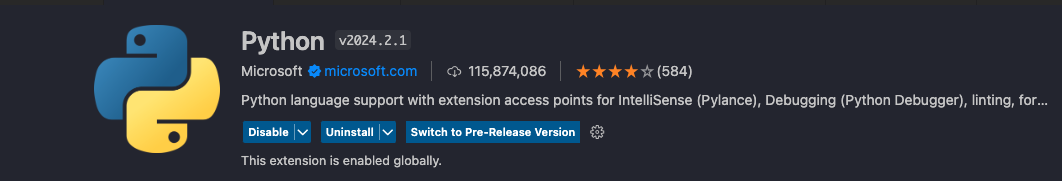

Dev Containers
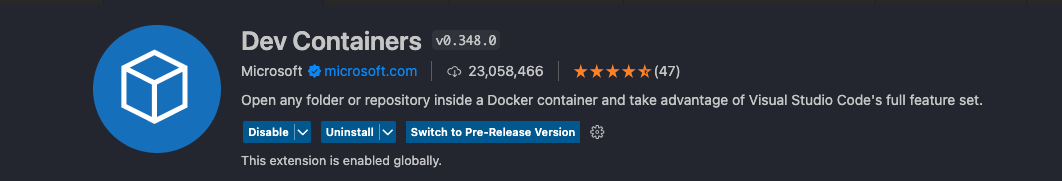

Also you need Docker Desktop to manage images and containers.

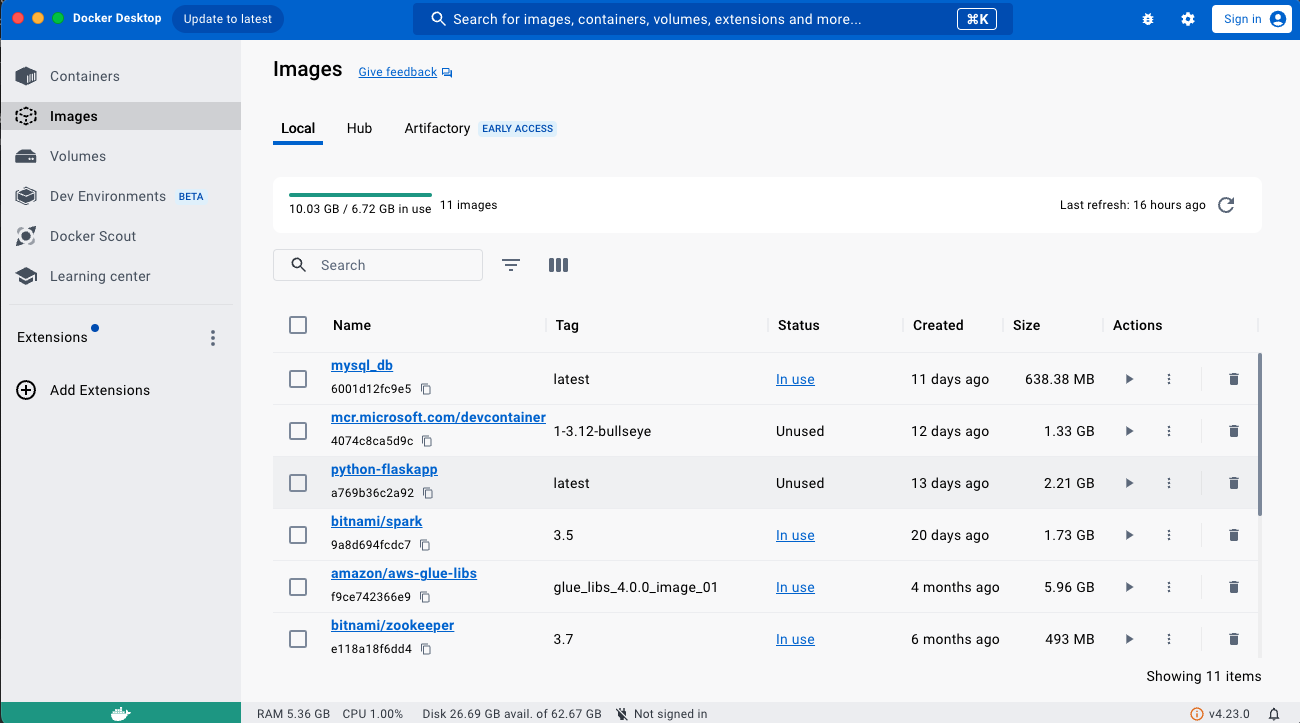

Ensure an AWS credentials to connect to your cloud account. Also verified you have required IAM permission to access data in S3.

### Installing and executing docker AWS Glue container

Download the image with the command:
```bash
docker pull amazon/aws-glue-libs:glue_libs_4.0.0_image_01
```

Create the workspace file to deploy the image in your project.

```json
{
    "python.defaultInterpreterPath": "/usr/bin/python3",
    "python.analysis.extraPaths": [
          "/home/glue_user/aws-glue-libs/PyGlue.zip:/home/glue_user/spark/python/lib/py4j-0.10.9-src.zip:/home/glue_user/spark/python/"
    ]
}
```
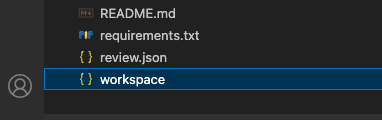

Once you have downloaded the image, run this sript to execute the Glue container.

```bash
docker run -it -v /Users/user/.aws/:/home/glue_user/.aws -v WORKSPACE_LOCATION:/home/glue_user/workspace/ -e AWS_PROFILE=default -e DISABLE_SSL=true --rm -p 4040:4040 -p 18080:18080 --name glue_pyspark amazon/aws-glue-libs:glue_libs_4.0.0_image_01 pyspark
```

The container will start and keep running.

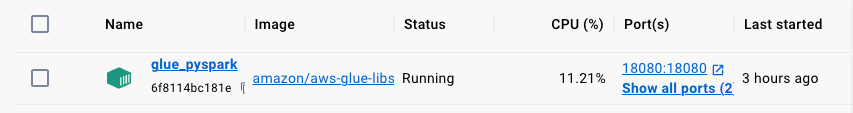

After go to dev container remote exlporer option and open attach the service in a new window. You will be able to see the new workspace with AWS Glue locally development workspace.

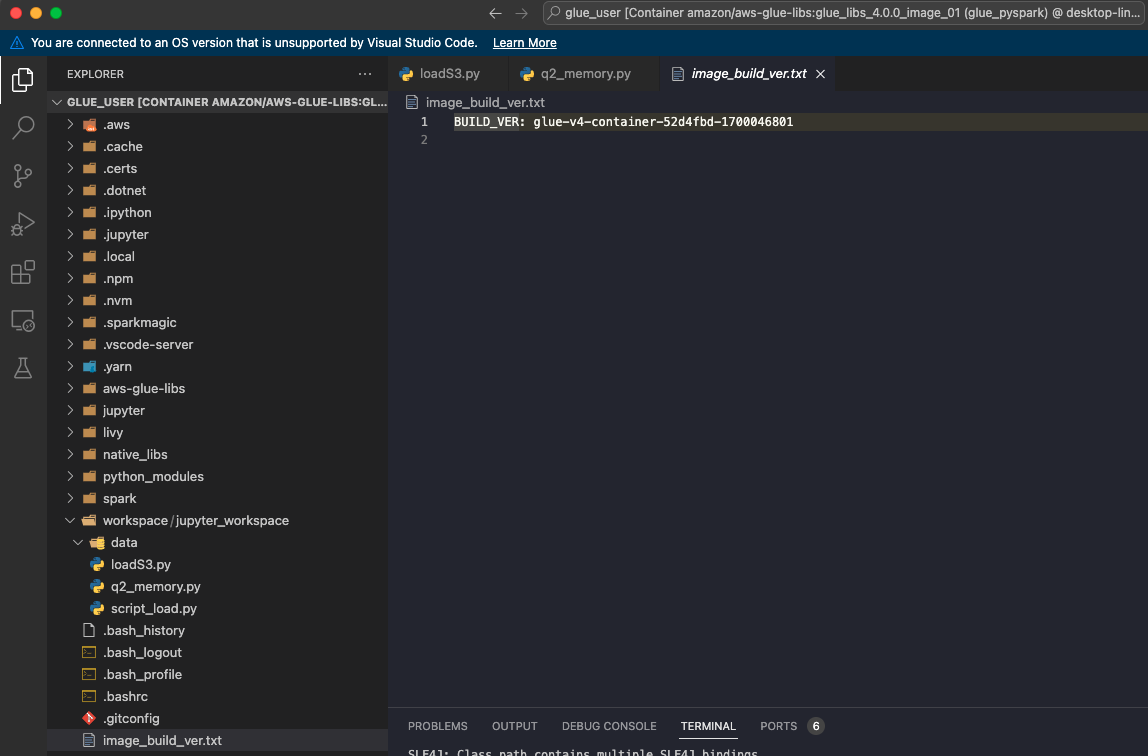

Don't forget upload data on S3 bucket.

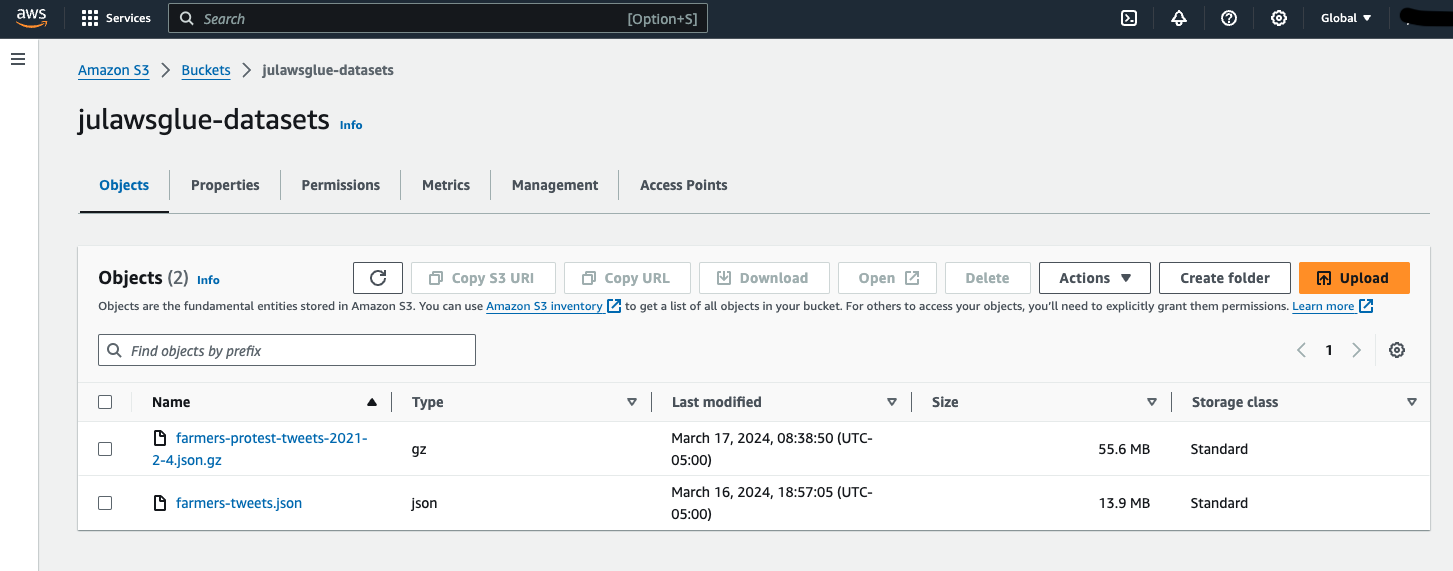

The code below is `q2_memory` deployed in AWS Glue service.

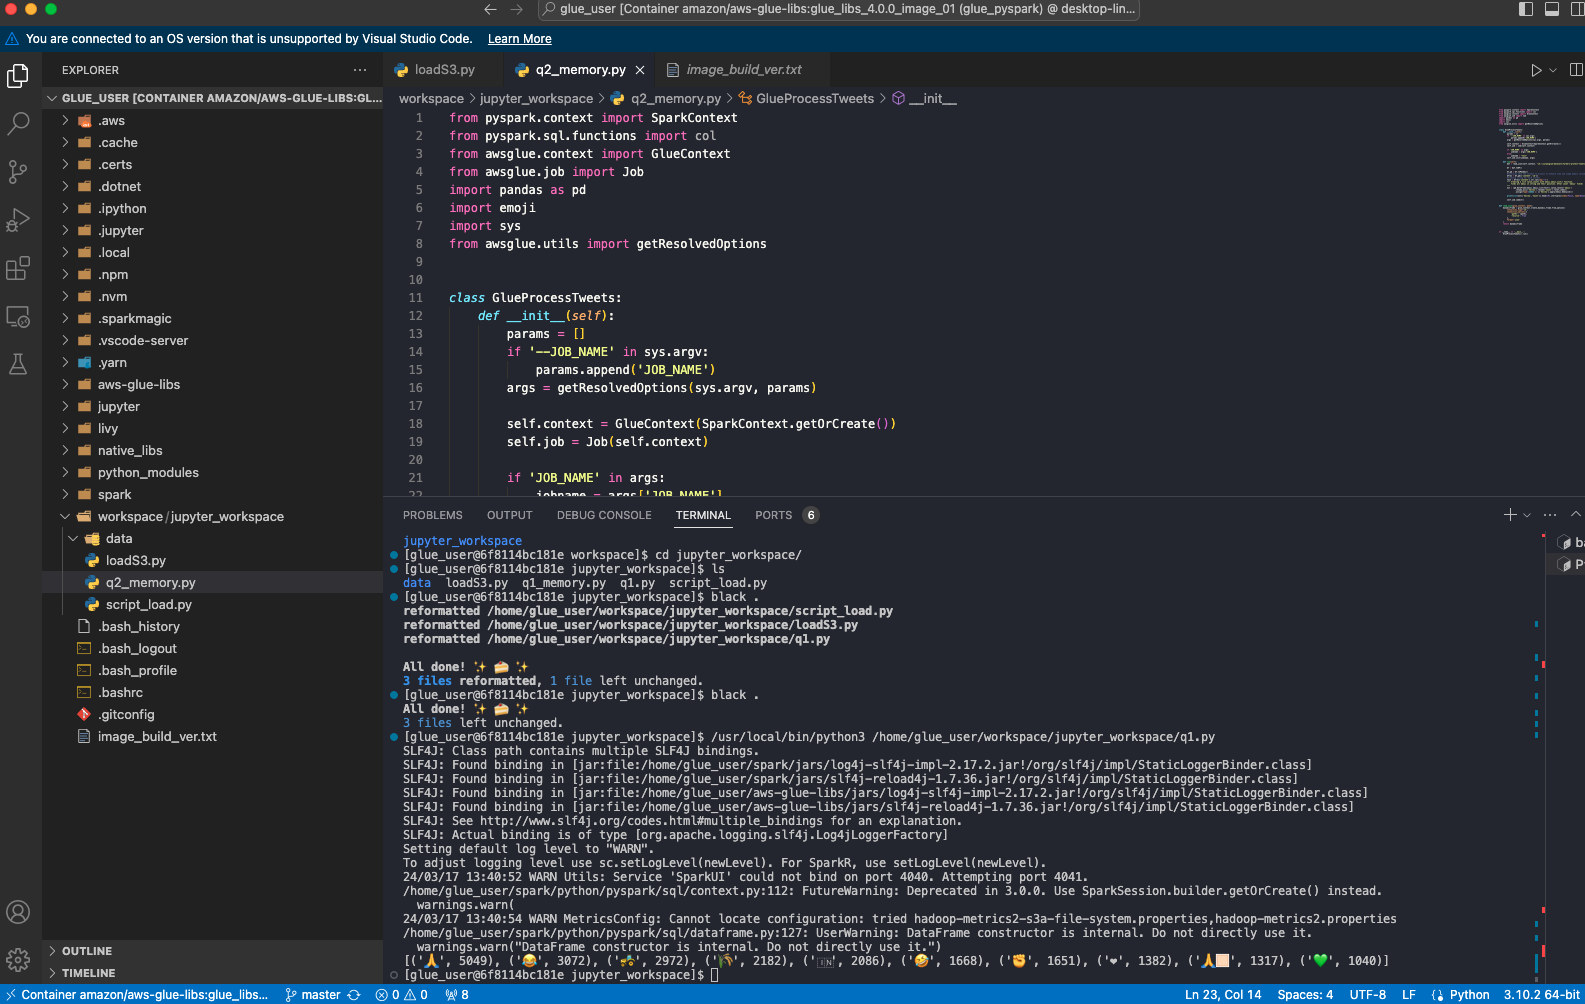

In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.functions import col
from awsglue.context import GlueContext
from awsglue.job import Job
import pandas as pd
import emoji
import sys
from awsglue.utils import getResolvedOptions


class GlueProcessTweets:
    def __init__(self):
        params = []
        if '--JOB_NAME' in sys.argv:
            params.append('JOB_NAME')
        args = getResolvedOptions(sys.argv, params)

        self.context = GlueContext(SparkContext.getOrCreate())
        self.job = Job(self.context)

        if 'JOB_NAME' in args:
            jobname = args['JOB_NAME']
        else:
            jobname = "test"
        self.job.init(jobname, args)

    def run(self):
        dyf = read_json(self.context, "s3://julawsglue-datasets/farmers-protest-tweets-2021-2-4.json.gz")
                
        df = dyf.toDF()
        
        df_pd = df.toPandas()
        #Selection only the columns to process to enhance time and usage memory consumption
        dfres = df_pd[['content','id']]
        #Creating string for each content
        text = dfres['content'].str.cat(sep='\n')
        """ Creating a list value_counts with emoji.emoji_list() function, 
            finds all emoji in string and their position. After count 'emoji' field)
        """
        out = (pd.DataFrame(emoji.emoji_list(text)).value_counts('emoji')
                .rename_axis('Smiley').rename('Count').reset_index()
                .assign(Type=lambda x: x['Smiley'].apply(emoji.demojize)))

        print(list(out[['Smiley','Count']].head(10).itertuples(index=False, name=None)))    

        self.job.commit()        


def read_json(glue_context, path):
    dynamicframe = glue_context.create_dynamic_frame.from_options(
        connection_type='s3',
        connection_options={
            'paths': [path],
            'recurse': True
        },
        format='json'
    )
    return dynamicframe



if __name__ == '__main__':
    GlueProcessTweets().run()

### Submit Post request

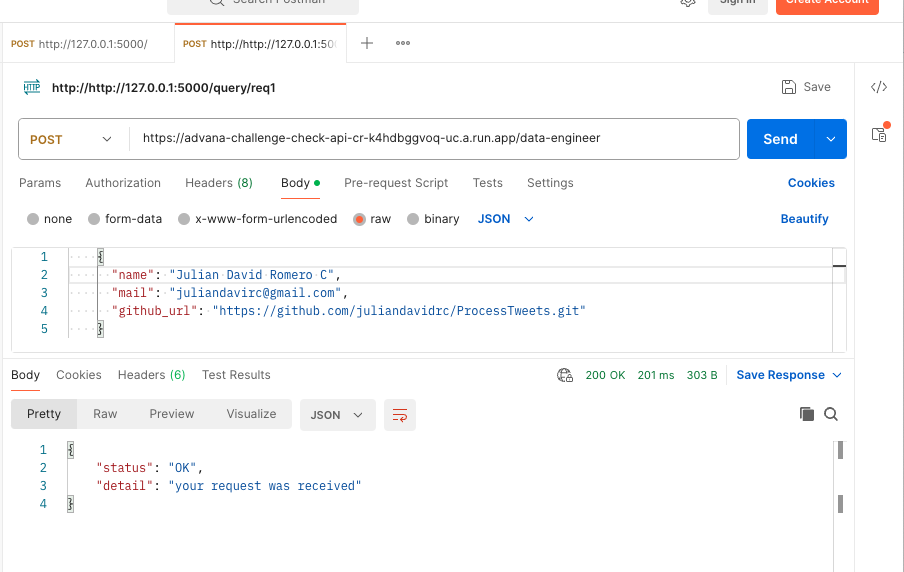